# Measure the performance of a  model that does image segmentaion

To gain insight on the performance of a given model, we look at:
* Metrics such as Logloss, RMSE, Dice Similarity Coefficient
* Random images from the validation dataset that were segmented with a high "accuracy".
* Random images from the validation dataset that were segmented with a low "accuracy".
* Images from the validation dataset that has a false segmentaion and high confidence/probability in the segmentation

These information may help uncover some shortcoming of the current model and help set the direction of new ways to improve the performance. 

## Imports

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.insert(0,"drive/zahraa5")

from helpersv4 import * 
import pickle
import mynnet5 as nn

/home/mas/.virtualenvs/cv/local/lib/python2.7/site-packages/pylidc/Scan.py:34: DeprecationWarning: The SafeConfigParser class has been renamed to ConfigParser in Python 3.2. This alias will be removed in future versions. Use ConfigParser directly instead.
  cp = configparser.SafeConfigParser()
/home/mas/.virtualenvs/cv/local/lib/python2.7/site-packages/pylidc/Scan.py:35: DeprecationWarning: You passed a bytestring as `filenames`. This will not work on Python 3. Use `cp.read_file()` or switch to using Unicode strings across the board.
  cp.read(cfgpath)


## Load data

In [2]:
train_data_path="data/JanTrain12_2.rec"
BATCH_SIZE=1
train_iter=nn.FileIter(train_data_path,batch_size=BATCH_SIZE,do_augment=True)
input_shapes = dict(train_iter.provide_data+train_iter.provide_label)
print(input_shapes)

{'softmax_label': (1, 32768), 'data': (1, 1, 32, 32, 32)}


In [3]:
valid_data_path="data/JanValid12_0.rec"
valid_iter=nn.FileIter(valid_data_path,batch_size=BATCH_SIZE,do_augment=False)
input_shapes = dict(valid_iter.provide_data+valid_iter.provide_label)
print(input_shapes)

{'softmax_label': (1, 32768), 'data': (1, 1, 32, 32, 32)}


## Evaluation Metrics

### The Dice Score

The dice score is an overlap metric frequently used for assessing the quaity of segmentation maps. It is defined as:
$$DSC = -\dfrac{2\left|P\wedge T\right|}{\left|P\right|+\left|T\right|}$$
Where $P$ and $T$ are two sets. The formation for bit vectors would be:
$$DSC = -\dfrac{2\left\|PT\right\|_2}{\left\|P\right\|^2_2+\left\|T\right\|^2_2}$$
Where $PT$ is the element-wise product of $P$ and $T$ and $\|X\|_2$ is the L2-Norm of X.

ref: https://arxiv.org/pdf/1701.03056.pdf

"Since the Dice Score itself is non-differentiable (since
the  predicted  segmentation  results  from  a  non-smoothly-differentiable binarization of the neural network outputs), our objective function was not, strictly speaking, the Dice
score for our model’s predictions. Rather than using the predicted segmentation,  we used the non-binarized predicted probabilities for each pixel.  Then, where X is the feature
map  of  predicted  probabilities  and  Y  is  the  groundtruth segmentation, we calculated our loss function as:
$$DSC(X,Y) = -2\dfrac{sum(X*Y)}{sum(X)+\left|Y\right|}"$$
ref: http://cs231n.stanford.edu/reports/2017/pdfs/526.pdf

Given an input of a 3D ct-scan, our neural network outputs a semantic segmentation of the volume that separates  the  nodule  from  the  rest  of  the  lung. The  final output is the same shape as the input, but each pixel of the output, rather than containing visual information, contains the unscaled probability that the corresponding pixel in the
input belongs to the nodule.  We generate our predicted segmentation by binarizing the predicted probabilities generated by our model, labeling each pixel with predicted probability greater than 0.5 as part of the nodule. 

The dice similiary coefficient is between  0 and =1. It is a loss function.  so the lower the better. 

The code implementation of the dice similarity coefficient is:

In [4]:
def dice_coef2(label, y):
    smooth = 1.
    label=mx.nd.array(label).as_in_context(mx.gpu(0))
    y=mx.nd.array(y).as_in_context(mx.gpu(0))
    intersection = mx.nd.sum(label*y)
    return (-(2. * intersection + smooth) / (mx.nd.sum(label) +mx.nd.sum(mx.nd.abs(y)) + smooth))

In [5]:
# ===============Evaluation metric(s)================= 
metric = mx.metric.CustomMetric(feval=dice_coef2)

## Load Model

In [6]:
model_path = "model/zMay28"
model_epoch=6000
network, arg_params, aux_params = mx.model.load_checkpoint(model_path , model_epoch)


# Binding
exe = network.simple_bind(ctx=mx.gpu(0), **input_shapes)
# get handle to input arrays
arg_arrays = dict(zip(network.list_arguments(), exe.arg_arrays))
data = arg_arrays[train_iter.provide_data[0][0]]
label = arg_arrays[train_iter.provide_label[0][0]]


exe.copy_params_from(arg_params, aux_params)

## Run Model

In [32]:
Es = []
start = time.time()

metric.reset()
valid_iter.reset()
    
for batch in valid_iter:        
    data[:] = batch.data[0]       
    label[:] = batch.label[0]
    # predict
    outputs = exe.forward(is_train=False)
    metric.update(batch.label[0], exe.outputs[0])
    Es.append(metric.get()[1].asnumpy()[0])
e=metric.get()
err_valid=e[1].asnumpy()[0]
end = time.time()
print('time:',end-start,'validloss:',err_valid)

('time:', 60.346551179885864, 'validloss:', -0.16026464)


## Examine Validation Dataset

Let us have a closer look at Es

In [41]:
def get_sample_at(valid_iter,n):
    valid_iter.reset()
    for i in range(n-1):
        valid_iter.next()
    return valid_iter.next()

In [34]:
len(Es),valid_iter.num_data

(511, 511)

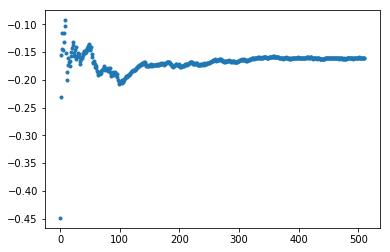

In [35]:
plt.plot(Es,'.')

In [36]:
np.mean(Es)

-0.16740245

In [37]:
Es[0:20]

[-0.44884384,
 -0.23164311,
 -0.15450905,
 -0.14464873,
 -0.11612944,
 -0.14529224,
 -0.1310378,
 -0.11472721,
 -0.1020615,
 -0.092531539,
 -0.15147333,
 -0.20057261,
 -0.18548065,
 -0.17235653,
 -0.16087455,
 -0.1676352,
 -0.17508866,
 -0.16557047,
 -0.15735225,
 -0.14966866]

In [38]:
# The most correct segmentation
ind = np.argsort(Es)
inds = list(ind[:4])
inds,[Es[i] for i in inds]

([0, 1, 99, 100], [-0.44884384, -0.23164311, -0.20755716, -0.20555608])

In [39]:
#The most wrong segmentation
ind[-4:],[Es[i] for i in ind[-4:]]

(array([4, 7, 8, 9]), [-0.11612944, -0.11472721, -0.1020615, -0.092531539])

## Most Wrong

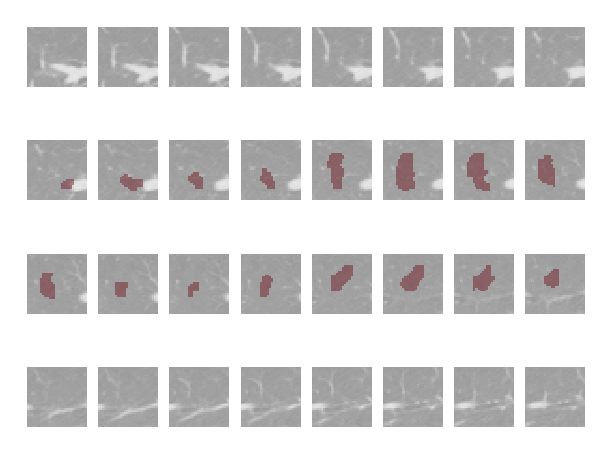

In [46]:
n=9
batch = get_sample_at(valid_iter,n)

data[:] = batch.data[0]     
label[:] = batch.label[0]

outputs = exe.forward(is_train=False)

p = outputs[0][0].asnumpy().reshape(32,32,32)



X = batch.data[0][0][0].asnumpy()
Y = batch.label[0][0].asnumpy().reshape((32,32,32))
                              
img = X
msk1 = Y
msk2 = p>.5#.001
msk2=msk2*1
msk1= np.ma.masked_where(msk1 == 0, msk1)
msk2= np.ma.masked_where(msk2 == 0, msk2)

zs=32
num_rows=np.ceil(zs/8).astype(int)
f, plots = plt.subplots(num_rows, 8, sharex='col', sharey='row', figsize=(10, 8))
for i in range(zs):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(img[i], cmap=plt.cm.gray,alpha=.4,vmin=0,vmax=1)
    plots[i // 8, i % 8].imshow(msk1[i],interpolation='none', cmap=plt.cm.Reds, alpha=.4, vmin=0, vmax=1)
    plots[i // 8, i % 8].imshow(msk2[i],interpolation='none', cmap=plt.cm.Greens, alpha=0.9, vmin=0, vmax=1)



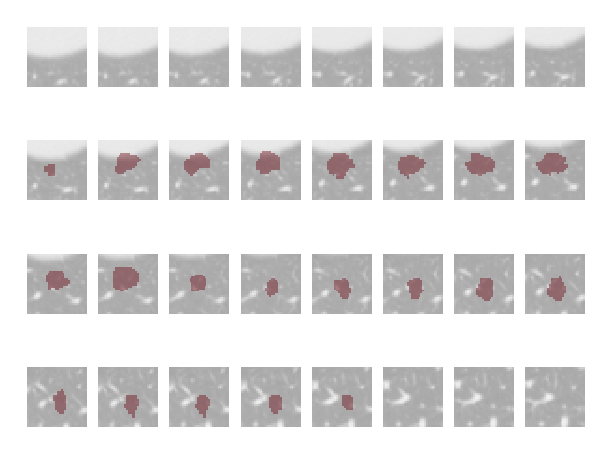

In [47]:
n=8
batch = get_sample_at(valid_iter,n)

data[:] = batch.data[0]     
label[:] = batch.label[0]

outputs = exe.forward(is_train=False)

p = outputs[0][0].asnumpy().reshape(32,32,32)



X = batch.data[0][0][0].asnumpy()
Y = batch.label[0][0].asnumpy().reshape((32,32,32))
                              
img = X
msk1 = Y
msk2 = p>.5#.001
msk2=msk2*1
msk1= np.ma.masked_where(msk1 == 0, msk1)
msk2= np.ma.masked_where(msk2 == 0, msk2)

zs=32
num_rows=np.ceil(zs/8).astype(int)
f, plots = plt.subplots(num_rows, 8, sharex='col', sharey='row', figsize=(10, 8))
for i in range(zs):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(img[i], cmap=plt.cm.gray,alpha=.4,vmin=0,vmax=1)
    plots[i // 8, i % 8].imshow(msk1[i],interpolation='none', cmap=plt.cm.Reds, alpha=.4, vmin=0, vmax=1)
    plots[i // 8, i % 8].imshow(msk2[i],interpolation='none', cmap=plt.cm.Greens, alpha=0.9, vmin=0, vmax=1)


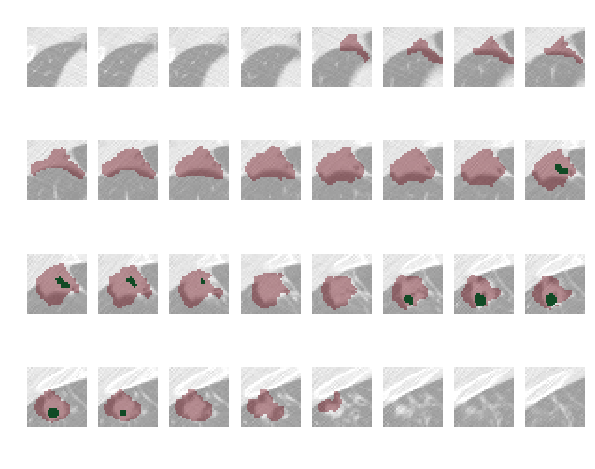

In [48]:
n=7
batch = get_sample_at(valid_iter,n)

data[:] = batch.data[0]     
label[:] = batch.label[0]

outputs = exe.forward(is_train=False)

p = outputs[0][0].asnumpy().reshape(32,32,32)



X = batch.data[0][0][0].asnumpy()
Y = batch.label[0][0].asnumpy().reshape((32,32,32))
                              
img = X
msk1 = Y
msk2 = p>.5#.001
msk2=msk2*1
msk1= np.ma.masked_where(msk1 == 0, msk1)
msk2= np.ma.masked_where(msk2 == 0, msk2)

zs=32
num_rows=np.ceil(zs/8).astype(int)
f, plots = plt.subplots(num_rows, 8, sharex='col', sharey='row', figsize=(10, 8))
for i in range(zs):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(img[i], cmap=plt.cm.gray,alpha=.4,vmin=0,vmax=1)
    plots[i // 8, i % 8].imshow(msk1[i],interpolation='none', cmap=plt.cm.Reds, alpha=.4, vmin=0, vmax=1)
    plots[i // 8, i % 8].imshow(msk2[i],interpolation='none', cmap=plt.cm.Greens, alpha=0.9, vmin=0, vmax=1)


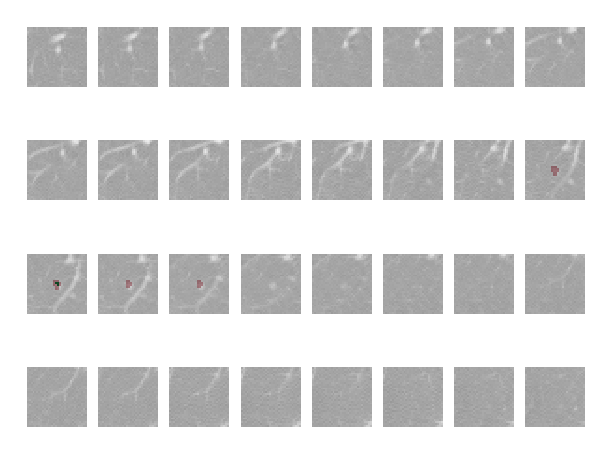

In [49]:
n=4
batch = get_sample_at(valid_iter,n)

data[:] = batch.data[0]     
label[:] = batch.label[0]

outputs = exe.forward(is_train=False)

p = outputs[0][0].asnumpy().reshape(32,32,32)



X = batch.data[0][0][0].asnumpy()
Y = batch.label[0][0].asnumpy().reshape((32,32,32))
                              
img = X
msk1 = Y
msk2 = p>.5#.001
msk2=msk2*1
msk1= np.ma.masked_where(msk1 == 0, msk1)
msk2= np.ma.masked_where(msk2 == 0, msk2)

zs=32
num_rows=np.ceil(zs/8).astype(int)
f, plots = plt.subplots(num_rows, 8, sharex='col', sharey='row', figsize=(10, 8))
for i in range(zs):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(img[i], cmap=plt.cm.gray,alpha=.4,vmin=0,vmax=1)
    plots[i // 8, i % 8].imshow(msk1[i],interpolation='none', cmap=plt.cm.Reds, alpha=.4, vmin=0, vmax=1)
    plots[i // 8, i % 8].imshow(msk2[i],interpolation='none', cmap=plt.cm.Greens, alpha=0.9, vmin=0, vmax=1)


## Most Correct

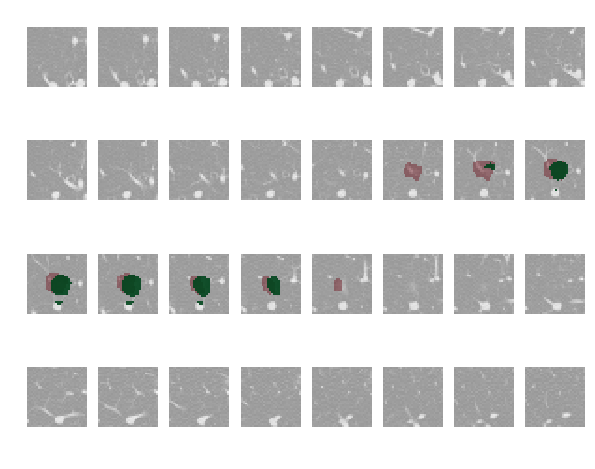

In [42]:
n=0
batch = get_sample_at(valid_iter,n)

data[:] = batch.data[0]     
label[:] = batch.label[0]

outputs = exe.forward(is_train=False)

p = outputs[0][0].asnumpy().reshape(32,32,32)



X = batch.data[0][0][0].asnumpy()
Y = batch.label[0][0].asnumpy().reshape((32,32,32))
                              
img = X
msk1 = Y
msk2 = p>.5#.001
msk2=msk2*1
msk1= np.ma.masked_where(msk1 == 0, msk1)
msk2= np.ma.masked_where(msk2 == 0, msk2)

zs=32
num_rows=np.ceil(zs/8).astype(int)
f, plots = plt.subplots(num_rows, 8, sharex='col', sharey='row', figsize=(10, 8))
for i in range(zs):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(img[i], cmap=plt.cm.gray,alpha=.4,vmin=0,vmax=1)
    plots[i // 8, i % 8].imshow(msk1[i],interpolation='none', cmap=plt.cm.Reds, alpha=.4, vmin=0, vmax=1)
    plots[i // 8, i % 8].imshow(msk2[i],interpolation='none', cmap=plt.cm.Greens, alpha=0.9, vmin=0, vmax=1)



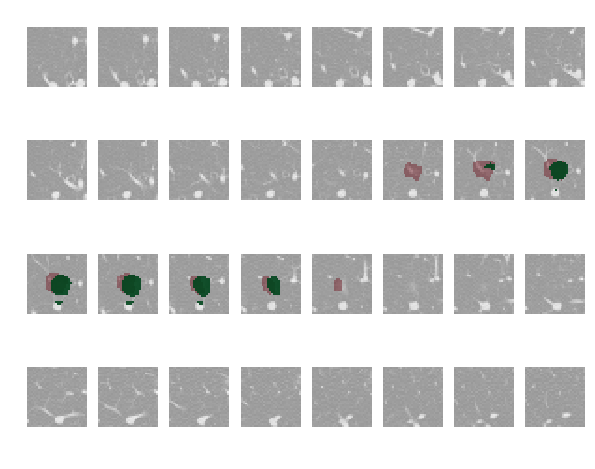

In [43]:
n=1
batch = get_sample_at(valid_iter,n)

data[:] = batch.data[0]     
label[:] = batch.label[0]

outputs = exe.forward(is_train=False)

p = outputs[0][0].asnumpy().reshape(32,32,32)



X = batch.data[0][0][0].asnumpy()
Y = batch.label[0][0].asnumpy().reshape((32,32,32))
                              
img = X
msk1 = Y
msk2 = p>.5#.001
msk2=msk2*1
msk1= np.ma.masked_where(msk1 == 0, msk1)
msk2= np.ma.masked_where(msk2 == 0, msk2)

zs=32
num_rows=np.ceil(zs/8).astype(int)
f, plots = plt.subplots(num_rows, 8, sharex='col', sharey='row', figsize=(10, 8))
for i in range(zs):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(img[i], cmap=plt.cm.gray,alpha=.4,vmin=0,vmax=1)
    plots[i // 8, i % 8].imshow(msk1[i],interpolation='none', cmap=plt.cm.Reds, alpha=.4, vmin=0, vmax=1)
    plots[i // 8, i % 8].imshow(msk2[i],interpolation='none', cmap=plt.cm.Greens, alpha=0.9, vmin=0, vmax=1)



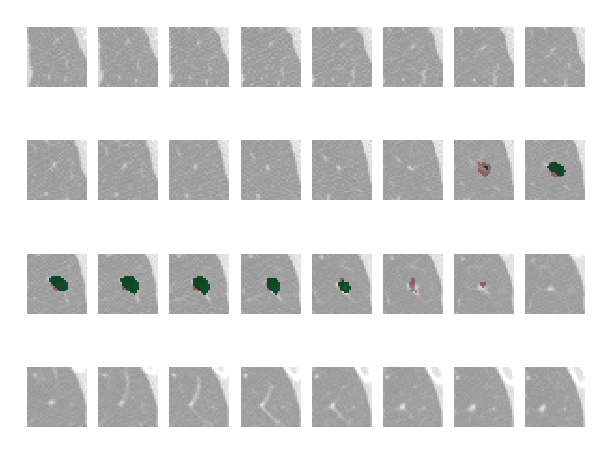

In [44]:
n=99
batch = get_sample_at(valid_iter,n)

data[:] = batch.data[0]     
label[:] = batch.label[0]

outputs = exe.forward(is_train=False)

p = outputs[0][0].asnumpy().reshape(32,32,32)



X = batch.data[0][0][0].asnumpy()
Y = batch.label[0][0].asnumpy().reshape((32,32,32))
                              
img = X
msk1 = Y
msk2 = p>.5#.001
msk2=msk2*1
msk1= np.ma.masked_where(msk1 == 0, msk1)
msk2= np.ma.masked_where(msk2 == 0, msk2)

zs=32
num_rows=np.ceil(zs/8).astype(int)
f, plots = plt.subplots(num_rows, 8, sharex='col', sharey='row', figsize=(10, 8))
for i in range(zs):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(img[i], cmap=plt.cm.gray,alpha=.4,vmin=0,vmax=1)
    plots[i // 8, i % 8].imshow(msk1[i],interpolation='none', cmap=plt.cm.Reds, alpha=.4, vmin=0, vmax=1)
    plots[i // 8, i % 8].imshow(msk2[i],interpolation='none', cmap=plt.cm.Greens, alpha=0.9, vmin=0, vmax=1)



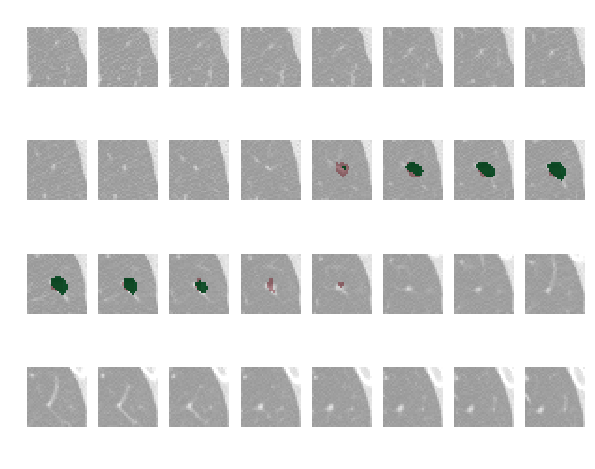

In [45]:
n=100
batch = get_sample_at(valid_iter,n)

data[:] = batch.data[0]     
label[:] = batch.label[0]

outputs = exe.forward(is_train=False)

p = outputs[0][0].asnumpy().reshape(32,32,32)



X = batch.data[0][0][0].asnumpy()
Y = batch.label[0][0].asnumpy().reshape((32,32,32))
                              
img = X
msk1 = Y
msk2 = p>.5#.001
msk2=msk2*1
msk1= np.ma.masked_where(msk1 == 0, msk1)
msk2= np.ma.masked_where(msk2 == 0, msk2)

zs=32
num_rows=np.ceil(zs/8).astype(int)
f, plots = plt.subplots(num_rows, 8, sharex='col', sharey='row', figsize=(10, 8))
for i in range(zs):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(img[i], cmap=plt.cm.gray,alpha=.4,vmin=0,vmax=1)
    plots[i // 8, i % 8].imshow(msk1[i],interpolation='none', cmap=plt.cm.Reds, alpha=.4, vmin=0, vmax=1)
    plots[i // 8, i % 8].imshow(msk2[i],interpolation='none', cmap=plt.cm.Greens, alpha=0.9, vmin=0, vmax=1)



On a a pixel level, we can think of the problem as a classification problem. Does this pixel belong to a nodule region or not. With this, I can compute the confusion matrix, where I can find the number of the total pixels that are true positive, false positive, true negative, false negative. 

In [61]:
Es = []
start = time.time()
y=[]
preds=[]

metric.reset()
valid_iter.reset()
    
for batch in valid_iter:        
    data[:] = batch.data[0]       
    label[:] = batch.label[0]
    # predict
    outputs = exe.forward(is_train=False)
    metric.update(batch.label[0], exe.outputs[0])
    Es.append(metric.get()[1].asnumpy()[0])
    y.append(batch.label[0][0].asnumpy())
    preds.append((outputs[0][0].asnumpy()>0.5)*1)
e=metric.get()
err_valid=e[1].asnumpy()[0]
end = time.time()
print('time:',end-start,'validloss:',err_valid)

('time:', 59.722848892211914, 'validloss:', -0.16026464)


In [69]:
y2 = [y2 for y1 in y for y2 in y1]

In [76]:
preds2 = [item for sublist in preds for item in sublist]

In [73]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[16090392    26563]
 [  588903    38590]]


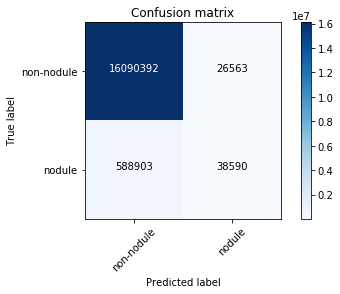

In [86]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y2, preds2)
plot_confusion_matrix(cm,['non-nodule','nodule'])

In [84]:
tn, fp, fn, tp = confusion_matrix(y2, preds2).ravel()

In [85]:
tn, fp, fn, tp

(16090392, 26563, 588903, 38590)